## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [2]:
data = pd.read_csv('downloads/autos.csv')
warnings.filterwarnings('ignore')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()
# в колонках Power и RegistrationYear есть выбросы.Большой вопрос нужно ли с ними что то делать.
# на данном этапе я думаю что оставлю их без изменений

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


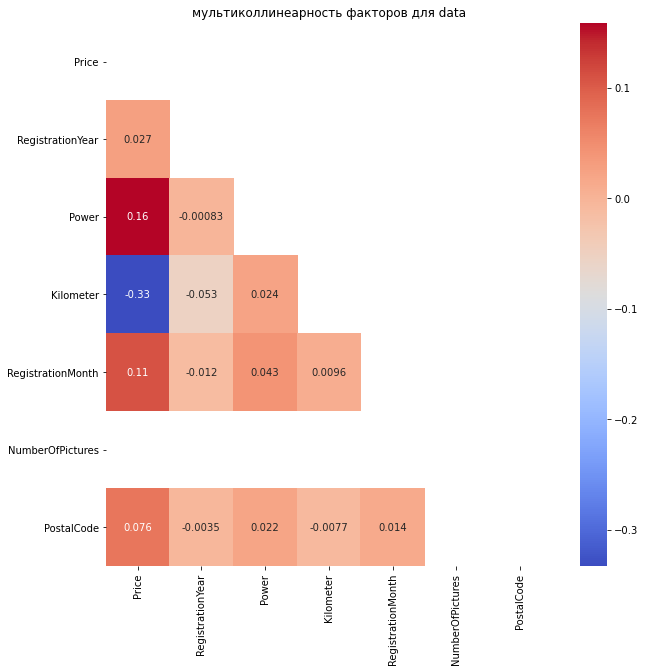

In [6]:
# проверка на мультиколлинеарность не дала явных зависимостей
matrix = np.triu(data.corr())
plt.figure(figsize=(10,10))
hm = sns.heatmap(data.corr(),cbar=True,annot=True,cmap= 'coolwarm',mask=matrix)
hm.set_title('мультиколлинеарность факторов для data');

In [7]:
# Хочу посмотреть количесвто пропусков по колонкам 
print('Nan значений в колонке NotRepaired:',data['NotRepaired'].isna().sum())
print('Nan значений в колонке FuelType:',data['FuelType'].isna().sum())
print('Nan значений в колонке VehicleType:',data['VehicleType'].isna().sum())
print('Nan значений в колонке Gearbox:',data['VehicleType'].isna().sum())

Nan значений в колонке NotRepaired: 71154
Nan значений в колонке FuelType: 32895
Nan значений в колонке VehicleType: 37490
Nan значений в колонке Gearbox: 37490


In [8]:
#хочу посмотреть типы кузовов
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [9]:
#хочу посмотреть распределние данных по типу кузова
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [10]:
# хочу посмотреть уникальные значения в колонке NotRepaired
data['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

In [11]:
# в типы кузова  вместо NAn значений поставлю 'unknown'
data['VehicleType'] = data['VehicleType'].fillna('unknown')
# в колонке NotRepaired так же много пропусков ,заменю их значениеем 'unknown'
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')
# в колонке NotRepaired так же много пропусков ,заменю их значениеем 'unknown'
data['FuelType'] = data['FuelType'].fillna('unknown')
# в колонке Model так же много пропусков ,заменю их значениеем 'unknown'
data['Model'] = data['Model'].fillna('unknown')
#в колонке Gearbox так же много пропусков ,заменю их значением 'unknown'
data['Gearbox'] = data['Gearbox'].fillna('unknown')

In [12]:
# удалю колонки из датасета:
data = data.drop(['NumberOfPictures'], axis=1)
data = data.drop(['DateCrawled'], axis=1)
data = data.drop(['DateCreated'], axis=1)
data = data.drop(['LastSeen'], axis=1)

In [13]:
# в колонке RegistrationYear много аномалий
data['RegistrationYear'].value_counts()

2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 151, dtype: int64

In [14]:
data['RegistrationYear'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [15]:
# в колонке Power много аномалий
data['Power'].value_counts()

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
323          1
3454         1
1056         1
13636        1
1158         1
Name: Power, Length: 712, dtype: int64

In [16]:
data['Power'].describe()

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [17]:
#собираюсь написать 2 функции для датасета,чтобы усранить аномалии в колонках RegistrationYear и Power
#функция magic для колонки RegistrationYear
def magic(row):
    if row < 1950:
        return 1950
    if row > 2021:
        return 2021
    else:
        return row
    
    
#функция prodigy для колокни Power
def prodigy(row):
    if row > 500:
        return 500
    else:
        return row
    
    
data['RegistrationYear'] = data['RegistrationYear'].apply(magic)
data['Power'] = data['Power'].apply(prodigy) 

In [18]:
data['RegistrationYear'].describe()

count    354369.000000
mean       2003.094718
std           7.439022
min        1950.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2021.000000
Name: RegistrationYear, dtype: float64

In [19]:
data['Power'].describe()

count    354369.000000
mean        106.894534
std          64.680768
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max         500.000000
Name: Power, dtype: float64

Я изучил датасет и применил к нему следующие действия:

- Вместо значений Nan проставил значения Unknown в колонках VehicleType,NotRepaired,FuelType,Model
- Удалил колонки NumberOfPictures,DateCrawled,DateCreated,LastSeen
- Я решил оставить выбросы хотя знаю что многие мои коллеги студенты убирали их,я подумал что заменив выбросы другими
- В колонке RegistrationYear удалил аномалии и оставил промежуток от 1950 до 2021 года
- В колонке Power удалил аномалии и оставил диапазон мощностей от 0 до 500 лошадиных сил значениями данные все равно будут 'исскуственными',поэтому оставил их без изменений

## Обучение моделей

In [20]:
#для начала хочу сделать хот энкодинг 
#а так же разделю датасет на признаки и таргет
data_ohe = pd.get_dummies(data, drop_first=True)
features = data_ohe.drop(['Price'], axis=1)
target = data_ohe['Price']
features_train, features_valid,target_train, target_valid = train_test_split(
    features, target, test_size=0.5, random_state=12345)
features_valid,features_test,target_valid,target_test = train_test_split(
    features_valid,target_valid,test_size=0.5,random_state=12345)
#Исследую размеры выборок
print('Размер обучающей выборки:',features_train.shape)
print('Размер валидационной выборки:',features_valid.shape)
print('Размер тестовой выборки:',features_test.shape)

Размер обучающей выборки: (177184, 313)
Размер валидационной выборки: (88592, 313)
Размер тестовой выборки: (88593, 313)


In [21]:
data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,1993,0,150000,0,70435,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190,125000,5,66954,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,90480,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,6,91074,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,7,60437,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#для начала создам модель линейной регресии
model_regression = LinearRegression().fit(features_train,target_train)
predict_regression = model_regression.predict(features_valid)
mse = mean_squared_error(target_valid,predict_regression)
rmse = mse ** 0.5
mae = mean_absolute_error(target_valid,predict_regression)
print('RMSE :',rmse)

RMSE : 2816.2760759365724


In [23]:
%%time
#создам модель случайного леса
model_forest = RandomForestRegressor(random_state=12345).fit(features_train,target_train)
predict_forest = model_forest.predict(features_valid)
mse = mean_squared_error(target_valid,predict_forest)
rmse = mse ** 0.5
mae = mean_absolute_error(target_valid,predict_forest)
print('RMSE :',rmse)

RMSE : 1752.487335325214
Wall time: 7min 17s


In [24]:
%%time
#постараюсь улучшить модель с RandomizedSearchCV
MSE = make_scorer(mse)
random_grid = {'max_depth': [10,100],
               'n_estimators': [130]}
random = RandomizedSearchCV(estimator = model_forest, param_distributions = random_grid, n_iter = 20, 
                               cv = 2, verbose=0, random_state=42)
random.fit(features_train,target_train)
print(random.best_params_)
#param_grid = { 
    #'n_estimators': [200, 500],
    #'max_depth' : [4,5,6,7,8],
#}
#cv = GridSearchCV(estimator=model_forest, param_grid=param_grid, cv= 5).fit(features_train,target_train)
#print(cv.best_params_)

#я попробовал 2 варианта и остановился на варианте RandomizedSearchCV так как он показал результат лучше

{'n_estimators': 130, 'max_depth': 100}
Wall time: 22min 52s


In [25]:
%%time
model_forest = RandomForestRegressor(random_state=12345,
                                     n_estimators=130,max_depth=100).fit(features_train,target_train)
predict_forest = model_forest.predict(features_valid)
mse = mean_squared_error(target_valid,predict_forest)
rmse = mse ** 0.5
mae = mean_absolute_error(target_valid,predict_forest)
print('RMSE :',rmse)

RMSE : 1750.138927550619
Wall time: 9min 56s


In [26]:
data['VehicleType'] = data['VehicleType'].astype('category')
data['RegistrationYear'] = data['RegistrationYear'].astype('category')
data['Gearbox'] = data['Gearbox'].astype('category')
data['Model'] = data['Model'].astype('category')
data['FuelType'] = data['FuelType'].astype('category')
data['Brand'] = data['Brand'].astype('category')
data['PostalCode'] = data['PostalCode'].astype('category')
data['NotRepaired'] = data['NotRepaired'].astype('category')
#теперь снова разобью данные на выборки
features_2 = data.drop(['Price'], axis=1)
target_2 = data['Price']
features_train_2, features_valid_2,target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.5, random_state=12345)
features_valid_2,features_test_2,target_valid_2,target_test_2 = train_test_split(
     features_valid_2,target_valid_2,test_size=0.5,random_state=12345)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              354369 non-null  int64   
 1   VehicleType        354369 non-null  category
 2   RegistrationYear   354369 non-null  category
 3   Gearbox            354369 non-null  category
 4   Power              354369 non-null  int64   
 5   Model              354369 non-null  category
 6   Kilometer          354369 non-null  int64   
 7   RegistrationMonth  354369 non-null  int64   
 8   FuelType           354369 non-null  category
 9   Brand              354369 non-null  category
 10  NotRepaired        354369 non-null  category
 11  PostalCode         354369 non-null  category
dtypes: category(8), int64(4)
memory usage: 14.5 MB


In [27]:
#создам модель градиентного бустинга
model = LGBMRegressor().fit(features_train_2,target_train_2,categorical_feature='auto')
predict = model.predict(features_valid_2)
mse = mean_squared_error(target_valid_2,predict)
rmse = mse ** 0.5
print('RMSE :',rmse)

RMSE : 1800.052830650608


In [28]:
#попробую улучшить показатели градиентного бустинга
params_test1={'max_depth': range(3,8,1), 'num_leaves':range(5, 100, 5)}
              
gsearch1 = GridSearchCV(estimator = LGBMRegressor(boosting_type='gbdt',objective='regression',metrics='mse',
                                                  learning_rate=0.1, n_estimators=20, max_depth=6, 
                                                  bagging_fraction = 0.8,feature_fraction = 0.8), 
                       param_grid = params_test1, cv=5,n_jobs=-1)
gsearch1.fit(features_train_2,target_train_2)
print(gsearch1.best_params_)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
{'max_depth': 7, 'num_leaves': 95}


In [29]:
params_test2={'max_bin': range(5,256,10), 'min_data_in_leaf':range(1,102,10)}

gsearch2 = GridSearchCV(estimator = LGBMRegressor(boosting_type='gbdt',
                                                  objective='regression',
                                                  metrics='mse',
                                                  learning_rate=0.1, 
                                                  n_estimators=20, 
                                                  max_depth=7,
                                                  num_leaves = 85, 
                                                  bagging_fraction = 0.8,
                                                  feature_fraction = 0.8), 
                       param_grid = params_test2, cv=5,n_jobs=-1)
gsearch2.fit(features_train_2,target_train_2)
print(gsearch2.best_params_)

{'max_bin': 245, 'min_data_in_leaf': 11}


In [30]:
params_test3={'feature_fraction': [0.6,0.7,0.8,0.9,1.0],
              'bagging_fraction': [0.6,0.7,0.8,0.9,1.0],
              'bagging_freq': range(0,81,10)
}
gsearch3 = GridSearchCV(estimator = LGBMRegressor(boosting_type='gbdt',
                                                  objective='regression',
                                                  metrics='mse',
                                                  learning_rate=0.1, 
                                                  n_estimators=20, 
                                                  max_depth=7,num_leaves = 85,
                                                  max_bin = 195,
                                                  min_data_in_leaf = 1, 
                                                  bagging_fraction = 0.8,
                                                  feature_fraction = 0.8), 
                       param_grid = params_test3, cv=5,n_jobs=-1)
gsearch3.fit(features_train_2,target_train_2)
print(gsearch3.best_params_)

{'bagging_fraction': 0.6, 'bagging_freq': 0, 'feature_fraction': 0.8}


In [31]:
%%time
#посмотрим улучшилась ли наша модель
model = LGBMRegressor(
max_depth=7,num_leaves=95,max_bin=245,min_data_in_leaf=11,bagging_fraction=0.6,bagging_freq=0,
feature_fraction=0.8).fit(features_train_2,target_train_2)
predict = model.predict(features_valid_2)
mse = mean_squared_error(target_valid_2,predict)
rmse = mse ** 0.5
mae = mean_absolute_error(target_valid_2,predict)
print('RMSE :',rmse)
if rmse < 1800.052830650608:
    print('Модель улучшилась')

RMSE : 1779.7100380915697
Модель улучшилась
Wall time: 1.54 s


Я сделал hot encoding для датасета ,а так же разбил данные на выборки-обучающаю,валидационную и тестовую.
Я обучил 3 модели:
- LinearRegression
- RandomForestRegressor
- LGBMRegressor

LinearRegression показала очень низкие результаты.RandomForestRegressor и LGBMRegressor показали значительно лучшие результаты,а подобрав к ним гиперпараметры я смог еще немного их улучшить.

## Анализ моделей

In [32]:
%%time
#собираюсь проанализировать модели на тестовой выборке 
#для начала модель случайного леса
model_forest = RandomForestRegressor(random_state=12345,
                                     n_estimators=130,max_depth=100).fit(features_train,target_train)

Wall time: 10min 36s


In [33]:
%%time
predict_forest = model_forest.predict(features_test)
mse = mean_squared_error(target_test,predict_forest)
rmse = mse ** 0.5
mae = mean_absolute_error(target_test,predict_forest)
print('RMSE :',rmse)

RMSE : 1743.6734010645612
Wall time: 4.94 s


In [34]:
%%time
#теперь модель градиентного бустинга
model = LGBMRegressor(
max_depth=7,num_leaves=95,max_bin=245,min_data_in_leaf=11,bagging_fraction=0.6,bagging_freq=0,
feature_fraction=0.8).fit(features_train_2,target_train_2)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Wall time: 1.02 s


In [35]:
%%time
predict = model.predict(features_test_2)
mse = mean_squared_error(target_test_2,predict)
rmse = mse ** 0.5
mae = mean_absolute_error(target_test_2,predict)
print('RMSE :',rmse)

RMSE : 1764.662817398292
Wall time: 271 ms


In [36]:
1743.6734010645612 / 1764.662817398292

0.988105707148816

In [38]:
final_df = pd.DataFrame({'test':['Качество предсказания RMSE','Скорость предсказания','Время обучения'],
                         'RandomForestRegressor':['1743.6734010645612','4.94 s','10min 36s'],
                         'LGBMRegressor':['1764.662817398292','271 ms','1.02 s']
                         })
final_df

,test,RandomForestRegressor,LGBMRegressor
0,Качество предсказания RMSE,1743.6734010645612,1764.662817398292
1,Скорость предсказания,4.94 s,271 ms
2,Время обучения,10min 36s,1.02 s


## Вывод

Для финального тестирования я отобрал 2 модели - RandomForestRegressor и LGBMRegressor.Точность случайного леса выше  на 
1.2% ,но время обучения модели намного ниже.LGBMRegressor справляется с обучением за 1 секунду ,в то время как случайному лесу для такой же задачи нужно  10 минут.Время предсказания моделей так же отличается - LGBMRegressor тратит на это  секунды ,а случайному лесу нужно почти 5 секунд.